In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 228ms/step - loss: 0.2809 - root_mean_squared_error: 0.5300 - val_loss: 0.1243 - val_root_mean_squared_error: 0.3526
Epoch 2/50
53/53 [==============================] - 11s 204ms/step - loss: 0.1083 - root_mean_squared_error: 0.3292 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1690
Epoch 3/50
53/53 [==============================] - 8s 155ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1520
Epoch 4/50
53/53 [==============================] - 1s 27ms/step - loss: 0.0272 - root_mean_squared_error: 0.1650 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1562
Epoch 5/50
53/53 [==============================] - 11s 205ms/step - loss: 0.0260 - root_mean_squared_error: 0.1613 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 6/50
53/53 [==============================] - 9s 164ms/step - loss: 0.0228 - root_mean_squared_error: 0.1512 - val_loss: 0.0190 - va

Epoch 35/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 36/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 37/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0124 - root_mean_squared_error: 0.1111 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 38/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 39/50
53/53 [==============================] - 11s 215ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 40/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0108 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.307959107557933 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

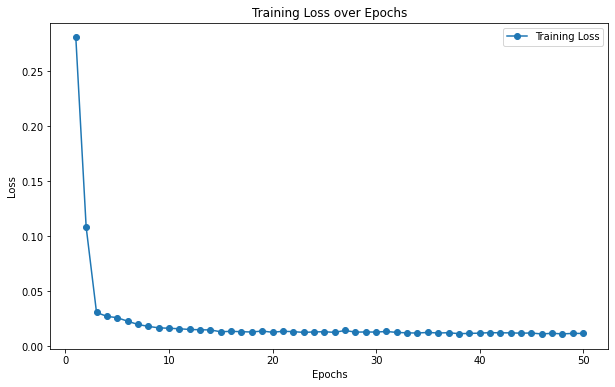

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

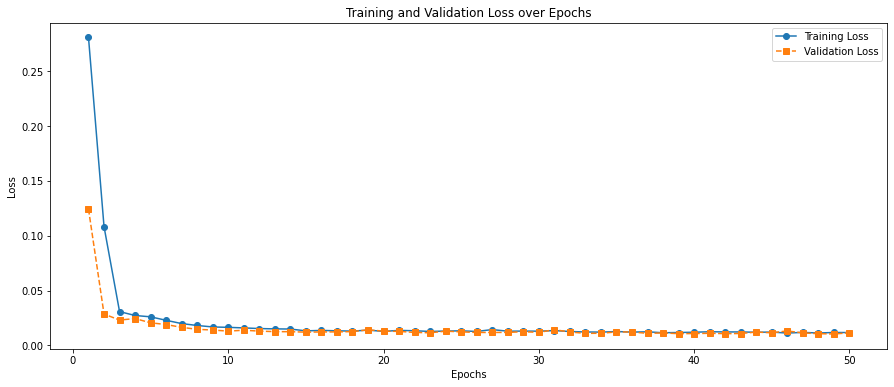

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 18ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.08860582223219858
MAE : 0.06893101819697559


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,446614.21875,604702.636
1,355264.46875,436530.907
2,289695.59375,283162.646
3,295704.81250,212475.431
4,349642.15625,386546.857
5,427228.78125,547183.986
6,492578.96875,584596.262
7,557438.37500,584830.109
8,609995.00000,641562.292
9,639762.68750,734946.437


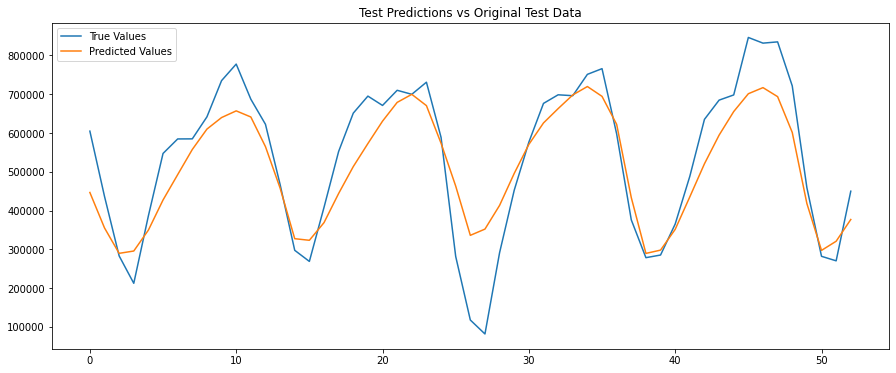

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

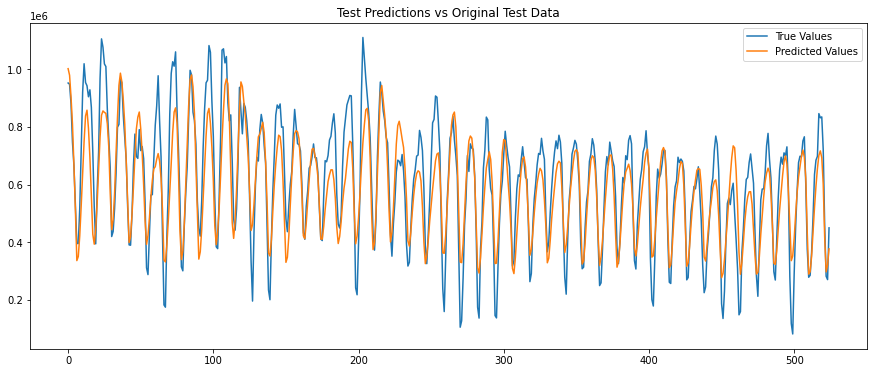

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()